# Water Potability - EDA using PySpark


This notebook performs exploratory data analysis (EDA) on the **Water Potability** dataset using **PySpark**.
The main goal is to analyze water quality features and identify trends between them and potability (drinkable or not).

- **1 = Potable (Safe to drink)**
- **0 = Not Potable**


In [1]:
from google.colab import files
uploaded = files.upload()


Saving water_potability.csv to water_potability.csv


In [2]:

from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("WaterPotabilityEDA").getOrCreate()


In [3]:

# Load dataset
df = spark.read.csv("water_potability.csv", header=True, inferSchema=True)

# Display schema and sample rows
df.printSchema()
df.show(5)


root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|             NULL| 204.890455471

In [4]:

from pyspark.sql.functions import col, when, count

# Count missing/null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|491|       0|     0|          0|    781|           0|             0|            162|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



In [5]:
# Get the original row count before cleaning
original_count = df.count()
print("Row count before cleaning:", original_count)

# Convert to Pandas and drop missing values
pandas_df = df.toPandas()
pandas_df = pandas_df.dropna()

# Recreate Spark DataFrame from the cleaned Pandas DataFrame
df_clean = spark.createDataFrame(pandas_df)

# Get the row count after cleaning
cleaned_count = df_clean.count()
print("Row count after cleaning:", cleaned_count)



Row count before cleaning: 3276
Row count after cleaning: 2011


In [6]:

# Describe numeric columns
from pyspark.sql.functions import round
desc_df = df_clean.describe()
rounded_df = desc_df.select([round(col(c).cast("double"), 2).alias(c) if c != "summary" else col(c) for c in desc_df.columns])
rounded_df.show()


+-------+------+--------+--------+-----------+-------+------------+--------------+---------------+---------+----------+
|summary|    ph|Hardness|  Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+-------+------+--------+--------+-----------+-------+------------+--------------+---------------+---------+----------+
|  count|2011.0|  2011.0|  2011.0|     2011.0| 2011.0|      2011.0|        2011.0|         2011.0|   2011.0|    2011.0|
|   mean|  7.09|  195.97|21917.44|       7.13| 333.22|      426.53|         14.36|           66.4|     3.97|       0.4|
| stddev|  1.57|   32.64| 8642.24|       1.58|  41.21|       80.71|          3.32|          16.08|     0.78|      0.49|
|    min|  0.23|   73.49|  320.94|       1.39|  129.0|      201.62|           2.2|           8.58|     1.45|       0.0|
|    max|  14.0|  317.34|56488.67|      13.13| 481.03|      753.34|         27.01|          124.0|     6.49|       1.0|
+-------+------+--------+--------+------

In [7]:

# Potability value distribution
df.groupBy("Potability").count().show()


+----------+-----+
|Potability|count|
+----------+-----+
|         1| 1278|
|         0| 1998|
+----------+-----+



In [8]:

# Mean of each column grouped by potability
mean_df = df_clean.groupBy("Potability").mean()

rounded_means = mean_df.select([
    round(col(c).cast("double"), 2).alias(c) if c != "Potability" else col(c)
    for c in mean_df.columns
])

rounded_means.show()


+----------+-------+-------------+-----------+----------------+------------+-----------------+-------------------+--------------------+--------------+---------------+
|Potability|avg(ph)|avg(Hardness)|avg(Solids)|avg(Chloramines)|avg(Sulfate)|avg(Conductivity)|avg(Organic_carbon)|avg(Trihalomethanes)|avg(Turbidity)|avg(Potability)|
+----------+-------+-------------+-----------+----------------+------------+-----------------+-------------------+--------------------+--------------+---------------+
|         0|   7.07|       196.01|   21628.54|            7.11|      333.74|           427.55|               14.4|               66.28|          3.96|            0.0|
|         1|   7.11|       195.91|   22344.92|            7.17|      332.46|           425.01|              14.29|               66.58|          3.99|            1.0|
+----------+-------+-------------+-----------+----------------+------------+-----------------+-------------------+--------------------+--------------+---------------

In [9]:

pandas_df.head()


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


In [10]:

import seaborn as sns
import matplotlib.pyplot as plt


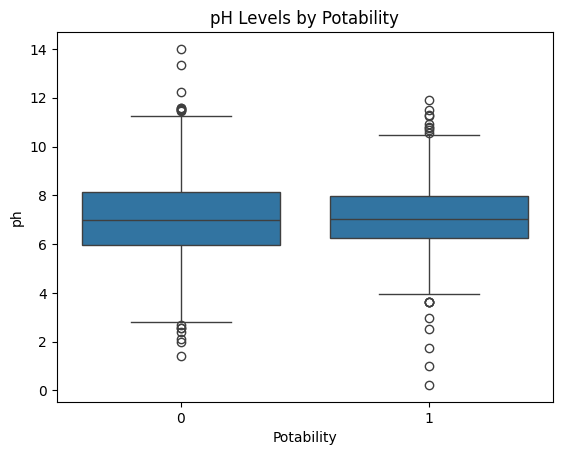

In [11]:

sns.boxplot(data=pandas_df, x='Potability', y='ph')
plt.title("pH Levels by Potability")
plt.show()


In [16]:
#!pip install pyspark

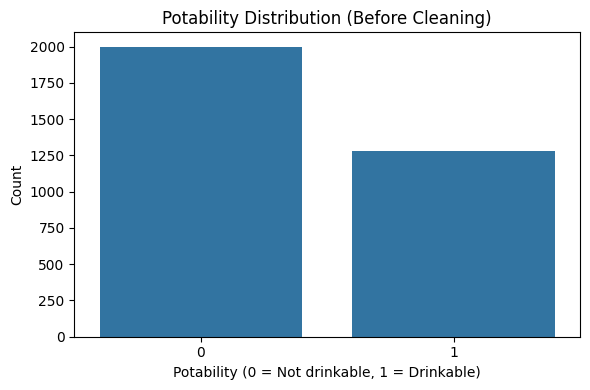

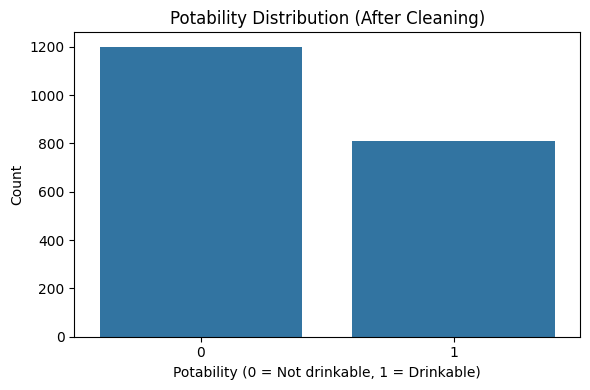

In [12]:
import pandas as pd

# Data before cleaning
pandas_df_before = df.toPandas()

# Data after cleaning
pandas_df_after = df.dropna()

# Plot potability before cleaning
plt.figure(figsize=(6, 4))
sns.countplot(data=pandas_df_before, x='Potability')
plt.title("Potability Distribution (Before Cleaning)")
plt.xlabel("Potability (0 = Not drinkable, 1 = Drinkable)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()  # Show the plot
plt.savefig("potability_distribution_before_cleaning.png")  # Save the plot
plt.close()

# Plot potability after cleaning
plt.figure(figsize=(6, 4))
# Use df_clean instead of df_cleaned
pandas_df_after = df_clean.toPandas()
sns.countplot(data=pandas_df_after, x='Potability')
plt.title("Potability Distribution (After Cleaning)")
plt.xlabel("Potability (0 = Not drinkable, 1 = Drinkable)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()  # Show the plot
plt.savefig("potability_distribution_after_cleaning.png")  # Save the plot
plt.close()

In [13]:
#4
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [14]:
# Step 4.1: Prepare features and label
# Replace 'data' with 'df_clean' which is the name of the cleaned DataFrame
feature_columns = df_clean.columns
feature_columns.remove('Potability')

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(df_clean) # Replace 'data' with 'df_clean' here as well

In [15]:
# Step 4.2: Split the data into training and testing sets
train_data, test_data = assembled_data.randomSplit([0.7, 0.3], seed=42)

In [16]:
# Step 4.3: Build Models

# Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='Potability')

# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Potability')

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='Potability', numTrees=100)


In [17]:
# Step 4.4: Train Models
lr_model = lr.fit(train_data)
dt_model = dt.fit(train_data)
rf_model = rf.fit(train_data)

In [18]:
# Step 4.5: Make Predictions
lr_predictions = lr_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)

In [19]:
# Step 4.6: Evaluate Models
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='Potability', predictionCol='prediction', metricName='accuracy')
evaluator_precision = MulticlassClassificationEvaluator(labelCol='Potability', predictionCol='prediction', metricName='weightedPrecision')
evaluator_recall = MulticlassClassificationEvaluator(labelCol='Potability', predictionCol='prediction', metricName='weightedRecall')
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='Potability', predictionCol='prediction', metricName='f1')

# Logistic Regression Evaluation
lr_accuracy = evaluator_accuracy.evaluate(lr_predictions)
lr_precision = evaluator_precision.evaluate(lr_predictions)
lr_recall = evaluator_recall.evaluate(lr_predictions)
lr_f1 = evaluator_f1.evaluate(lr_predictions)

# Decision Tree Evaluation
dt_accuracy = evaluator_accuracy.evaluate(dt_predictions)
dt_precision = evaluator_precision.evaluate(dt_predictions)
dt_recall = evaluator_recall.evaluate(dt_predictions)
dt_f1 = evaluator_f1.evaluate(dt_predictions)

# Random Forest Evaluation
rf_accuracy = evaluator_accuracy.evaluate(rf_predictions)
rf_precision = evaluator_precision.evaluate(rf_predictions)
rf_recall = evaluator_recall.evaluate(rf_predictions)
rf_f1 = evaluator_f1.evaluate(rf_predictions)


In [20]:
results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy],
    'Precision': [lr_precision, dt_precision, rf_precision],
    'Recall': [lr_recall, dt_recall, rf_recall],
    'F1-Score': [lr_f1, dt_f1, rf_f1]
}

results_df = pd.DataFrame(results)

print(results_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.575488   0.543754  0.575488  0.426710
1        Decision Tree  0.612789   0.603558  0.612789  0.595836
2        Random Forest  0.646536   0.688287  0.646536  0.589239


In [21]:
# Convert predictions to Pandas DataFrame
lr_preds = lr_predictions.select('prediction', 'Potability').toPandas()
dt_preds = dt_predictions.select('prediction', 'Potability').toPandas()
rf_preds = rf_predictions.select('prediction', 'Potability').toPandas()


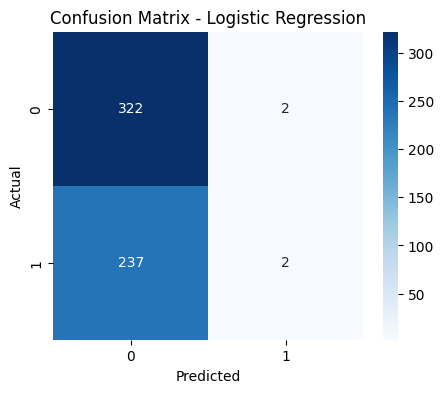

In [23]:
from sklearn.metrics import confusion_matrix # Import confusion_matrix

cm_lr = confusion_matrix(lr_preds['Potability'], lr_preds['prediction'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

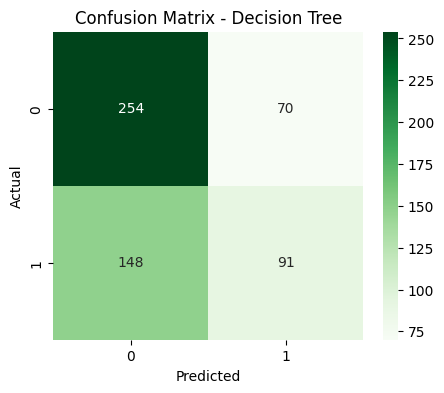

In [24]:
cm_dt = confusion_matrix(dt_preds['Potability'], dt_preds['prediction'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


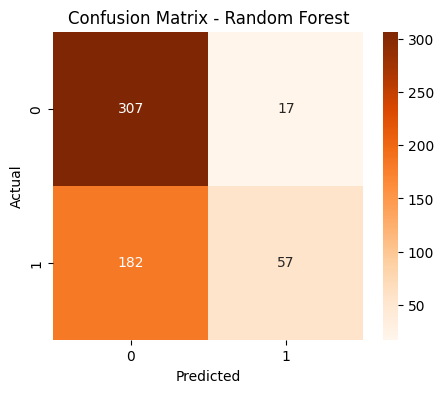

In [25]:
cm_rf = confusion_matrix(rf_preds['Potability'], rf_preds['prediction'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


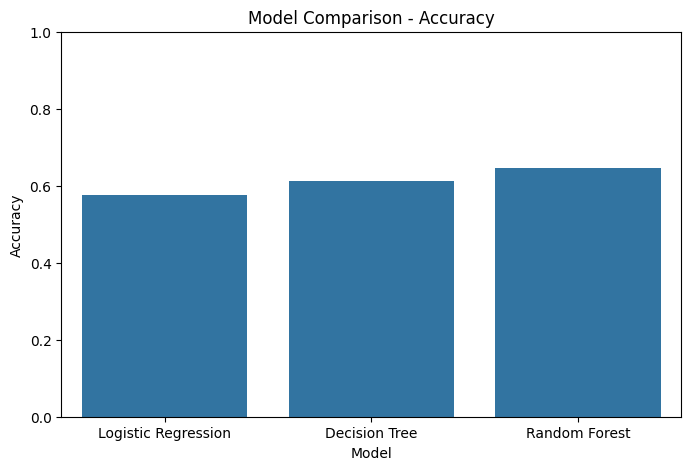

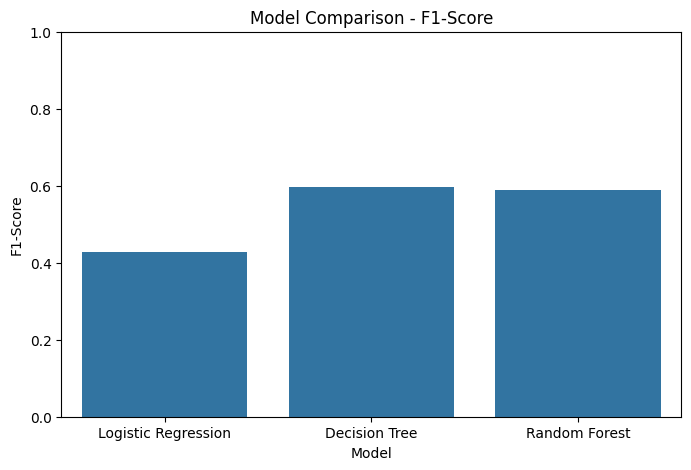

In [26]:
# Prepare performance results
performance_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy],
    'F1-Score': [lr_f1, dt_f1, rf_f1]
}

performance_df = pd.DataFrame(performance_data)

# Plot Bar Chart for Accuracy
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=performance_df)
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot Bar Chart for F1-Score
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='F1-Score', data=performance_df)
plt.title('Model Comparison - F1-Score')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.show()


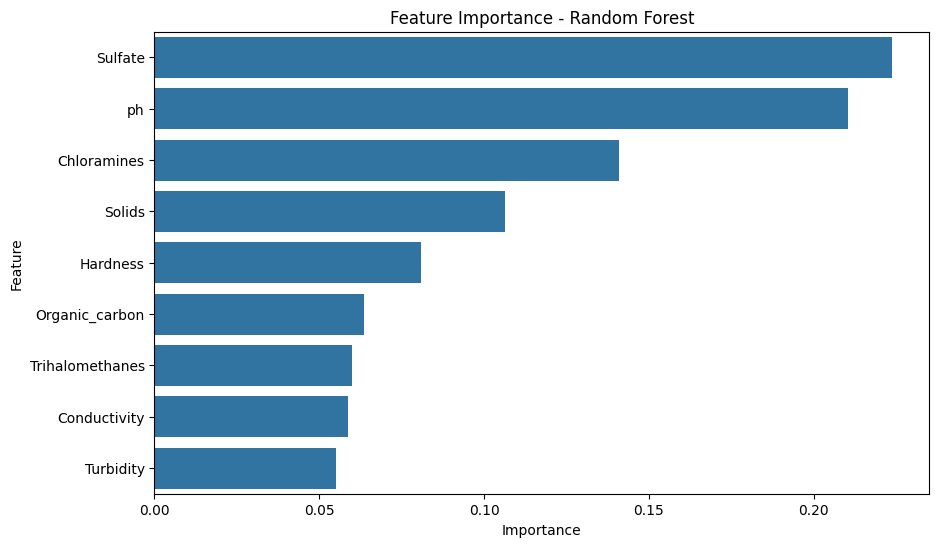

In [27]:
# Extract feature importances from the Random Forest model
importances = rf_model.featureImportances

# Convert feature importances to Pandas DataFrame
features_list = feature_columns
importance_df = pd.DataFrame({
    'Feature': features_list,
    'Importance': importances.toArray()
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Random Forest')
plt.show()
